In [98]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *

In [99]:
pd.set_option('display.max_columns', None)

In [100]:
c_folder="../../data/calibration/"
d_folder="../../data/runData/"
r_n=287
pulsed=True

Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
p_folder="../../plots/run_"+str(r_n)+"/"

In [101]:
%%time
p,m,r=import_data(c_folder,d_folder, r_n, is_it_pulsed=pulsed)

CPU times: user 3.94 s, sys: 784 ms, total: 4.72 s
Wall time: 4.72 s


In [105]:
#r.groupby(["layer", "strip"]).count()

In [106]:
%%time
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=pulsed) #this needs to be run as it's own cell

Number of events: 7800


Initial pedestal-based selection performed.
Events left: 7764


CPU times: user 311 ms, sys: 103 ms, total: 414 ms
Wall time: 411 ms


In [107]:
if pulsed:
    r.drop(list(r.filter(regex = 'adc_.?_end.?')), axis = 1, inplace = True)
    r.drop(["Unnamed: 0"], axis=1, inplace=True)

In [108]:
pulse_df=pd.read_csv(d_folder+"run_"+str(r_n)+"_pulse_problems.csv", index_col="index")

filtered_df=r.drop(["pf_event", "layer", "strip",
                    "pedestal_per_time_sample_std_dev_end0", "pedestal_per_time_sample_std_dev_end1",
                    "adc_mean_end0", "adc_mean_end1"], axis=1)

In [109]:
big_df=filtered_df.merge(pulse_df, left_index=True, right_index=True)

In [110]:
non_TOT=big_df[(big_df["tot_end0"]==0) & (big_df["tot_end1"]==0)]

In [111]:
wavy=non_TOT[non_TOT["problem_type"]=="WAVE"]
late=non_TOT[non_TOT["problem_type"]=="LATE"]
spiky=non_TOT[(non_TOT["problem_type"]=="SPIKE_0") | (non_TOT["problem_type"]=="SPIKE_1")]

In [112]:
wavy_all=big_df[big_df["problem_type"]=="WAVE"]
late_all=big_df[big_df["problem_type"]=="LATE"]
spiky_all=big_df[(big_df["problem_type"]=="SPIKE_0") | (big_df["problem_type"]=="SPIKE_1")]

In [113]:
hand_bins=np.linspace(50,7250,51)

a,_=np.histogram(non_TOT["adc_sum_end0"], bins=hand_bins)
w,_=np.histogram(wavy["adc_sum_end0"], bins=hand_bins)
l,_=np.histogram(late["adc_sum_end0"], bins=hand_bins)
s,_=np.histogram(spiky["adc_sum_end0"], bins=hand_bins)

a_all,_=np.histogram(big_df["adc_sum_end0"], bins=hand_bins)
w_all,_=np.histogram(wavy_all["adc_sum_end0"], bins=hand_bins)
l_all,_=np.histogram(late_all["adc_sum_end0"], bins=hand_bins)
s_all,_=np.histogram(spiky_all["adc_sum_end0"], bins=hand_bins)

wavy_share=w/a
late_share=l/a
spiky_share=s/a

wavy_share_all=w_all/a_all
late_share_all=l_all/a_all
spiky_share_all=s_all/a_all

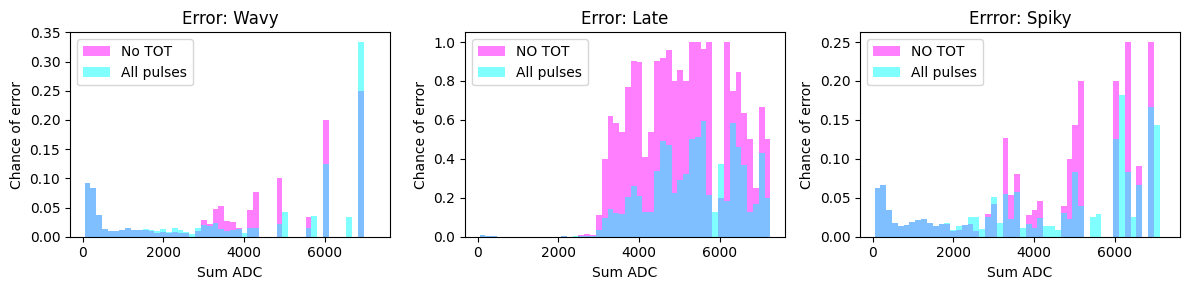

In [114]:
plt.rcParams["figure.figsize"]=(12,3)

plt.subplot(1,3,1)
plt.title("Error: Wavy")
plt.hist(hand_bins[:-1],hand_bins,weights= wavy_share, alpha=0.5, color="magenta", label="No TOT")
plt.hist(hand_bins[:-1],hand_bins,weights= wavy_share_all, alpha=0.5, color="cyan", label="All pulses")
plt.xlabel("Sum ADC")
plt.ylabel("Chance of error")
plt.legend()

plt.subplot(1,3,2)
plt.title("Error: Late")
plt.hist(hand_bins[:-1],hand_bins,weights= late_share, alpha=0.5, color="magenta", label="NO TOT")
plt.hist(hand_bins[:-1],hand_bins,weights= late_share_all, alpha=0.5, color="cyan", label="All pulses")
plt.xlabel("Sum ADC")
plt.ylabel("Chance of error")
plt.legend()

plt.subplot(1,3,3)
plt.title("Errror: Spiky")
plt.hist(hand_bins[:-1],hand_bins,weights= spiky_share, alpha=0.5, color="magenta", label="NO TOT")
plt.hist(hand_bins[:-1],hand_bins,weights= spiky_share_all, alpha=0.5, color="cyan", label="All pulses")
plt.xlabel("Sum ADC")
plt.ylabel("Chance of error")
plt.legend()

plt.tight_layout()

plt.savefig(p_folder+"error_energy_spectrum.png", bbox_inches='tight')
plt.show()

In [115]:
events_by_layer=big_df.groupby(["layer"]).count()[["event"]]

wave_chance=big_df[big_df["problem_type"]=="WAVE"].groupby(["layer"]).count()[["event"]]/events_by_layer
late_chance=big_df[big_df["problem_type"]=="LATE"].groupby(["layer"]).count()[["event"]]/events_by_layer
spike0_chance=big_df[big_df["problem_type"]=="SPIKE_0"].groupby(["layer"]).count()[["event"]]/events_by_layer
spike1_chance=big_df[big_df["problem_type"]=="SPIKE_1"].groupby(["layer"]).count()[["event"]]/events_by_layer

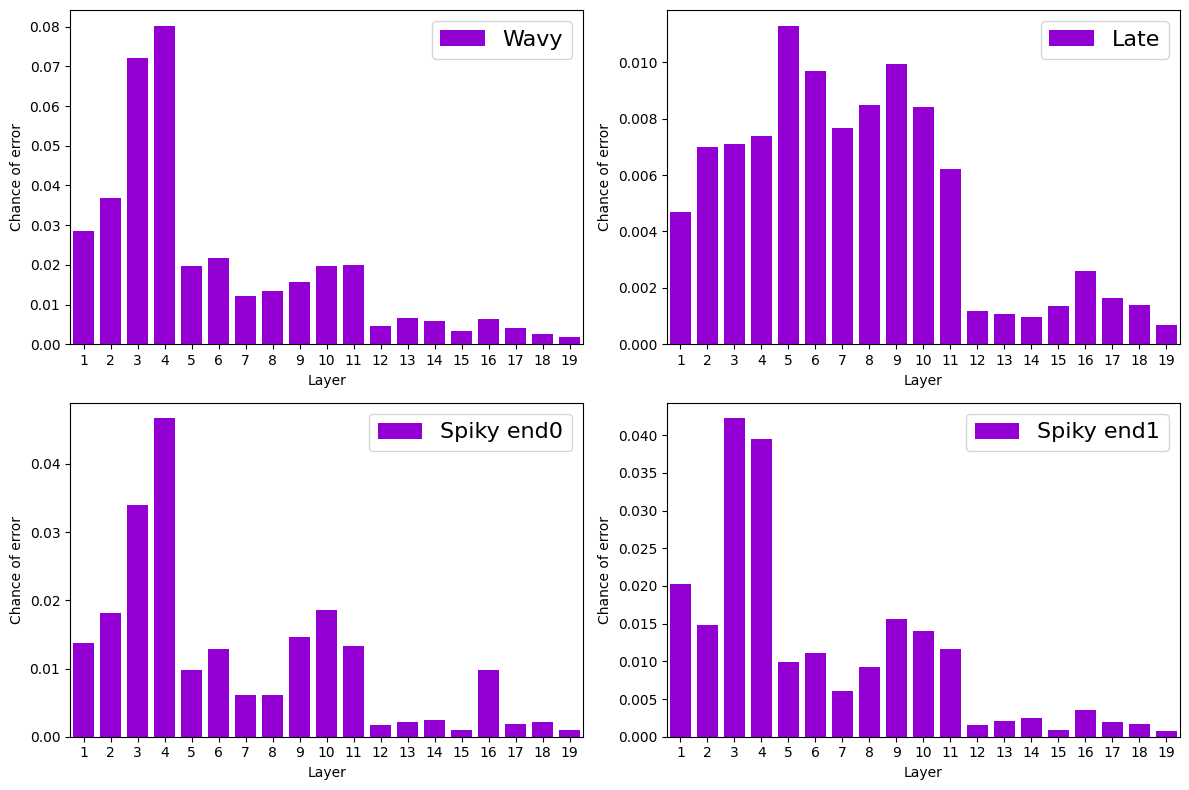

In [116]:
plt.rcParams["figure.figsize"]=(12,8)
plt.subplot(2,2,1)
plt.bar(wave_chance.index,wave_chance["event"],color="darkviolet", label="Wavy")
plt.xlim(0.5,19.5)
plt.xticks(np.arange(1,20))
plt.xlabel("Layer")
plt.ylabel("Chance of error")
plt.legend(loc="upper right", prop={'size': 16})

plt.subplot(2,2,2)
plt.bar(late_chance.index,late_chance["event"],color="darkviolet", label="Late")
plt.xlim(0.5,19.5)
plt.xticks(np.arange(1,20))
plt.xlabel("Layer")
plt.ylabel("Chance of error")
plt.legend(loc="upper right", prop={'size': 16})

plt.subplot(2,2,3)
plt.bar(spike0_chance.index,spike0_chance["event"],color="darkviolet", label="Spiky end0")
plt.xlim(0.5,19.5)
plt.xticks(np.arange(1,20))
plt.xlabel("Layer")
plt.ylabel("Chance of error")
plt.legend(loc="upper right", prop={'size': 16})

plt.subplot(2,2,4)
plt.bar(spike1_chance.index,spike1_chance["event"],color="darkviolet", label="Spiky end1")
plt.xlim(0.5,19.5)
plt.xticks(np.arange(1,20))
plt.xlabel("Layer")
plt.ylabel("Chance of error")
plt.legend(loc="upper right", prop={'size': 16})

plt.tight_layout()
plt.savefig(p_folder+"layer_error_spectrum.png", bbox_inches="tight")
plt.show()

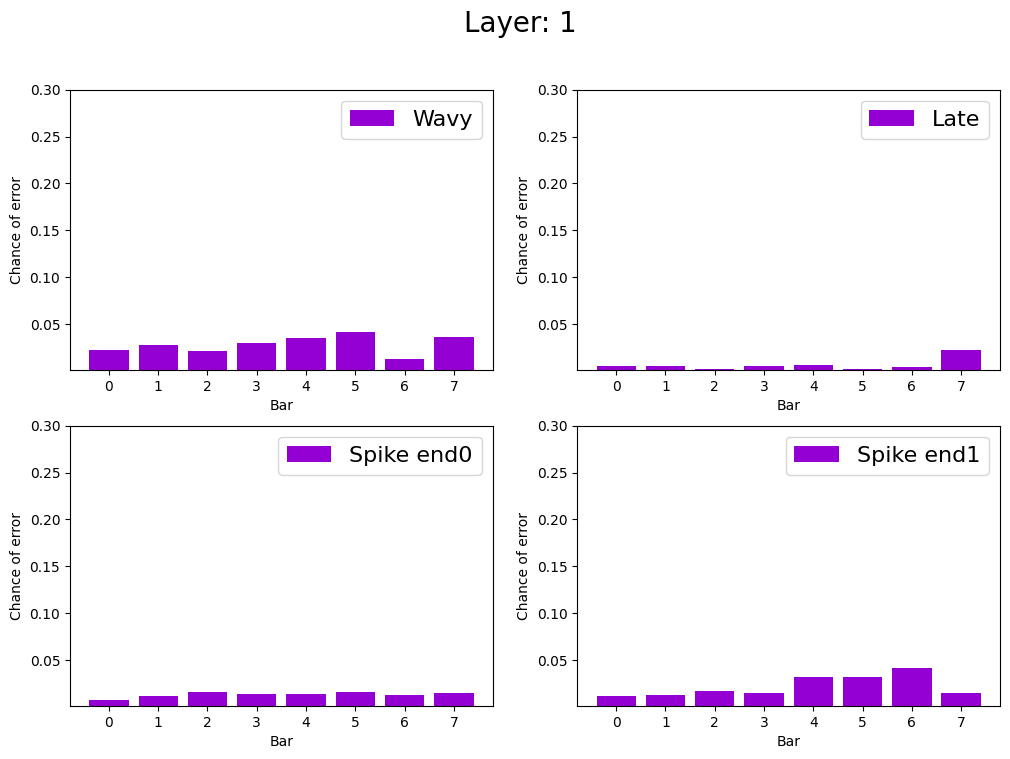

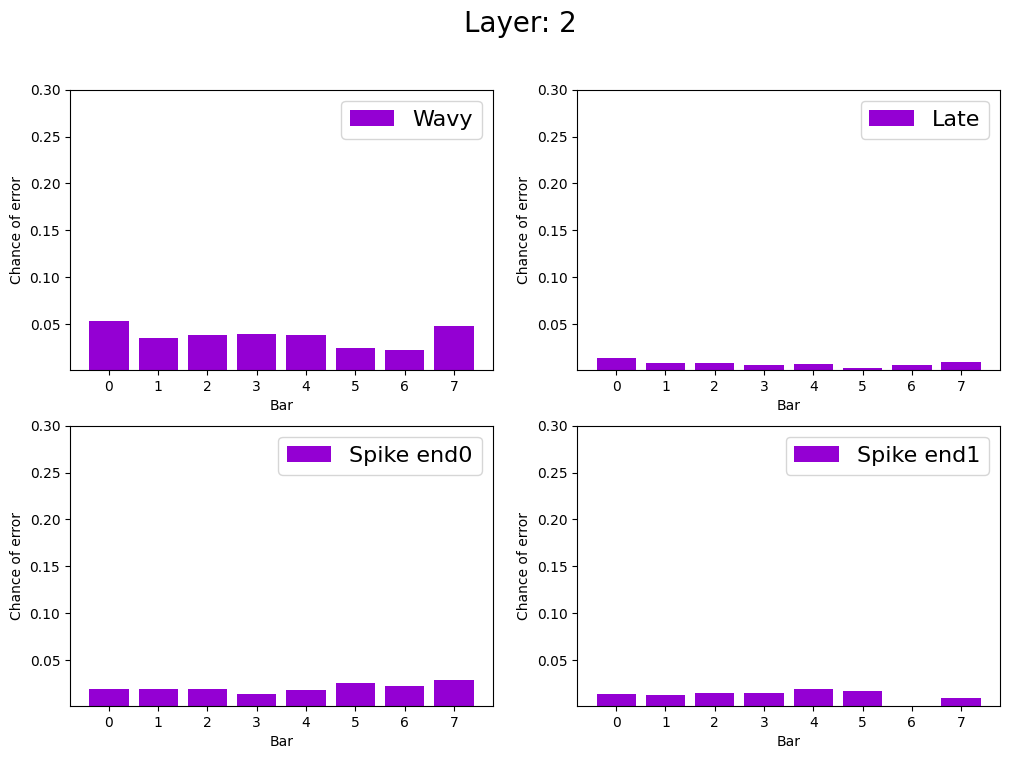

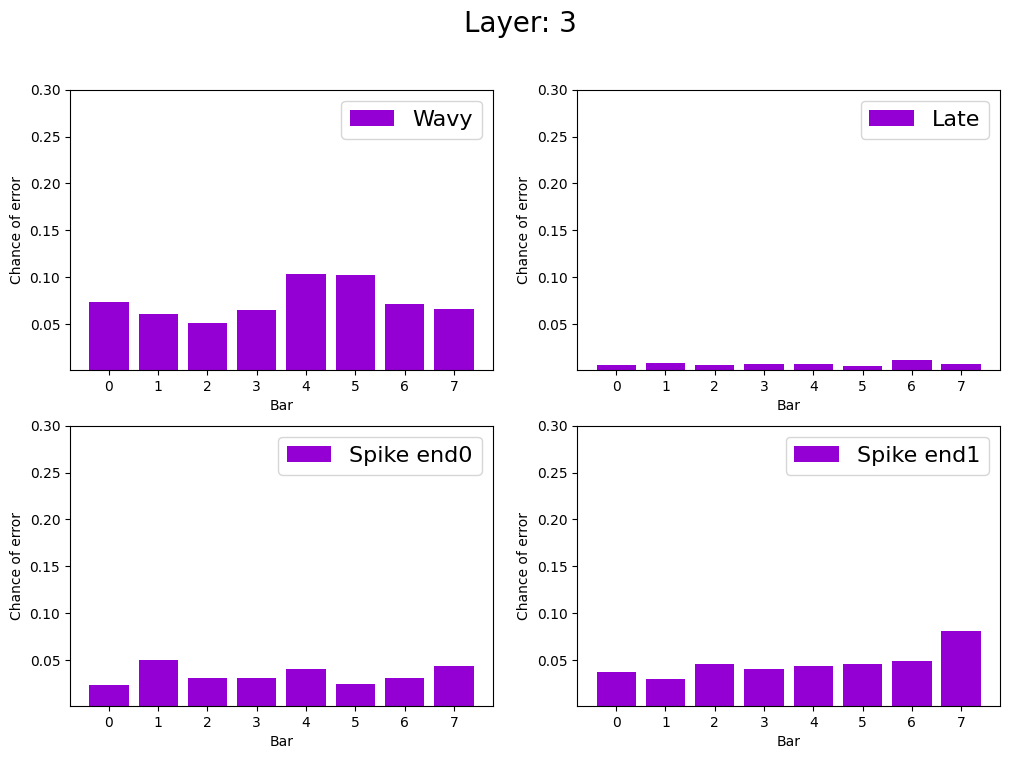

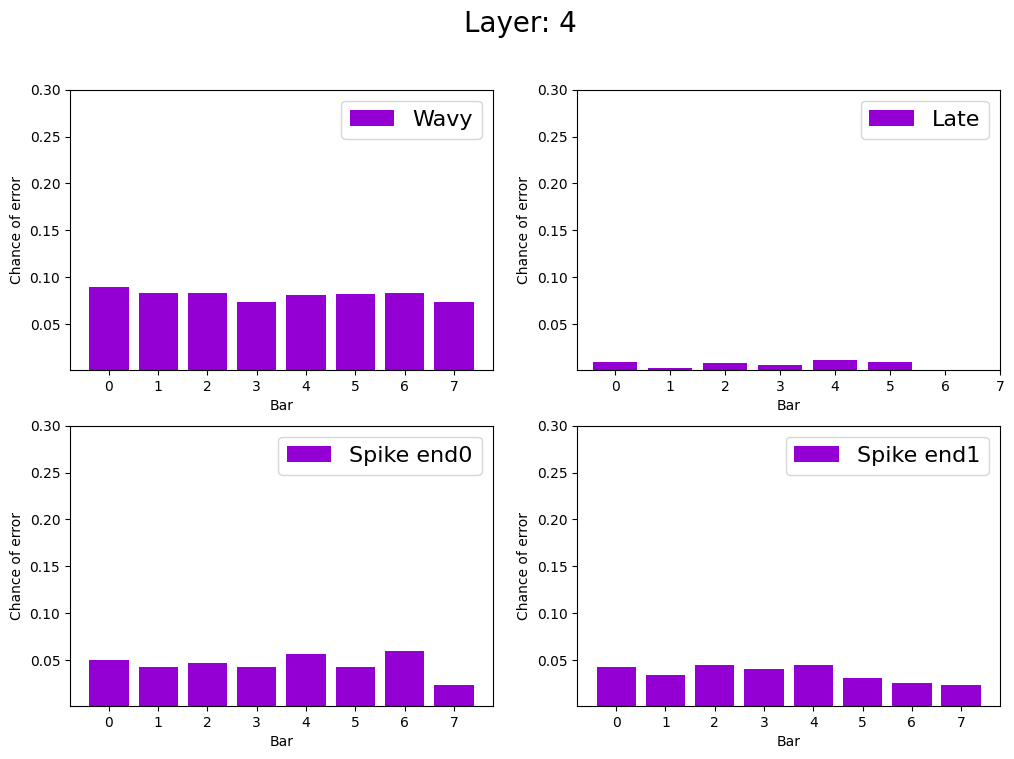

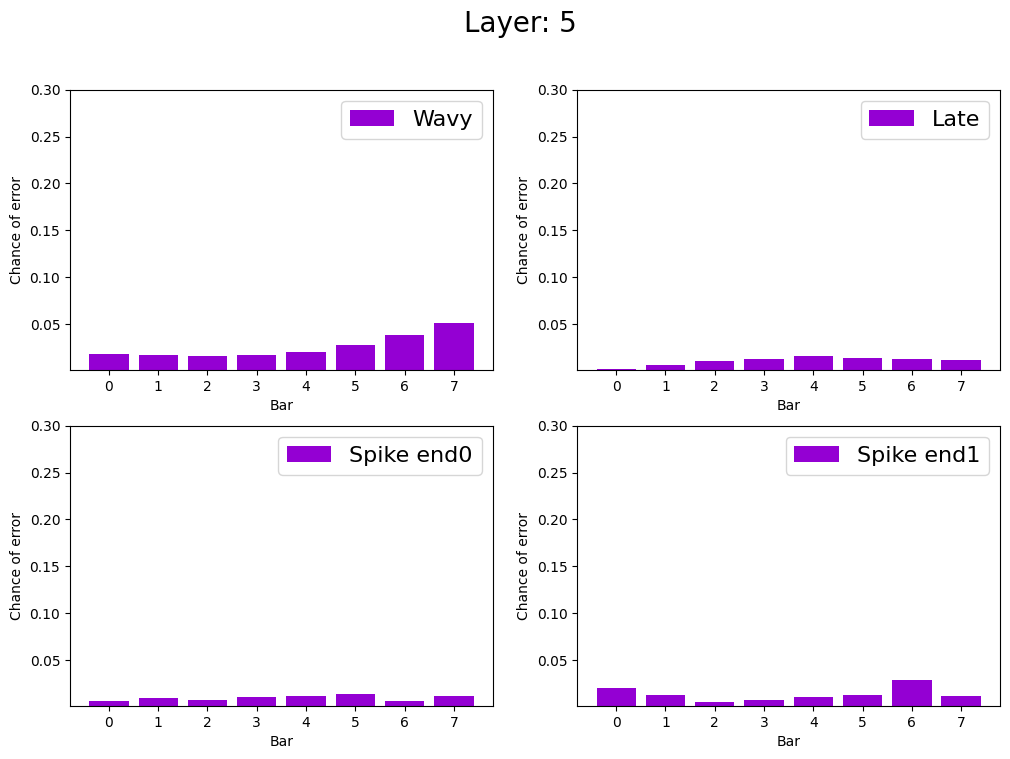

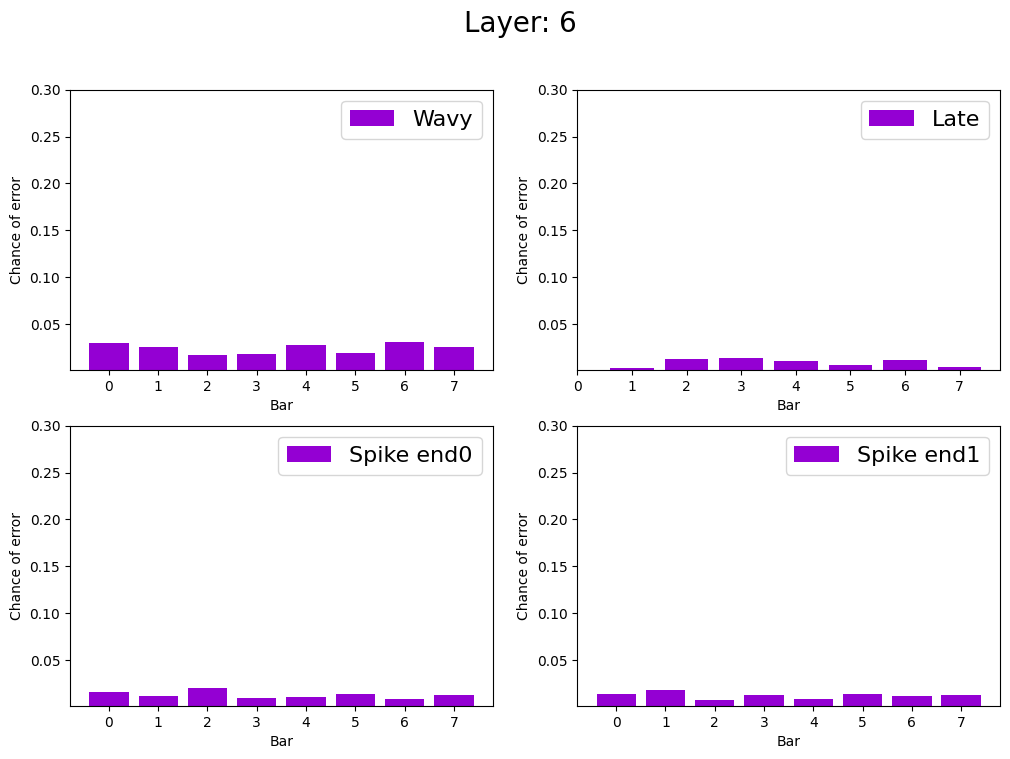

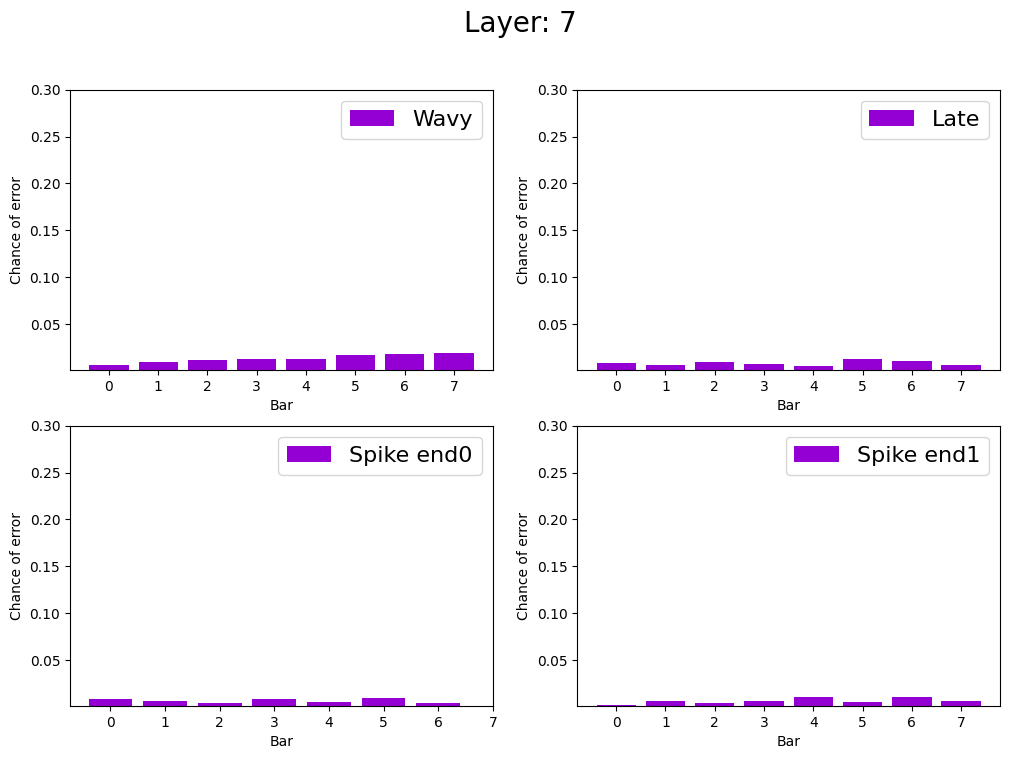

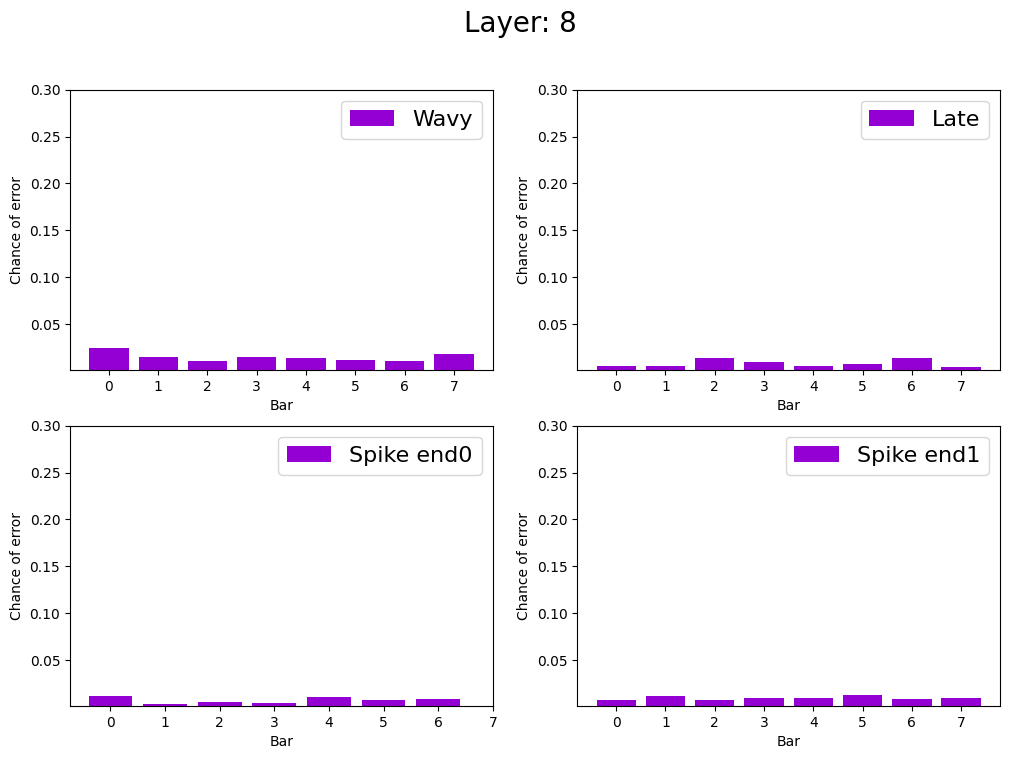

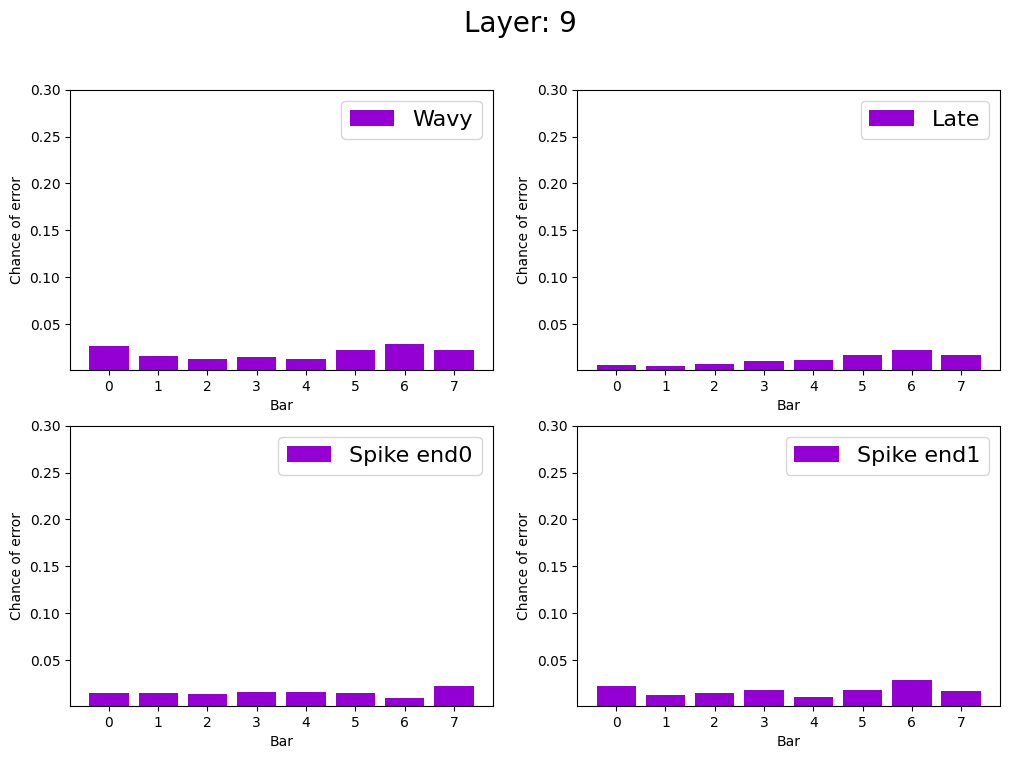

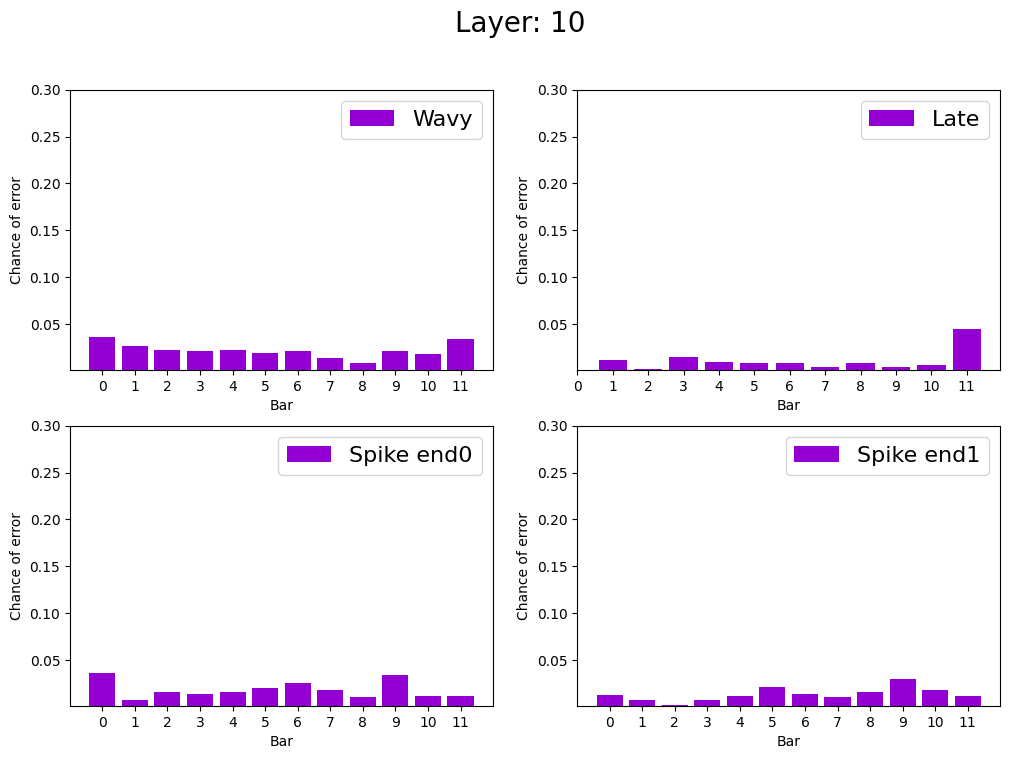

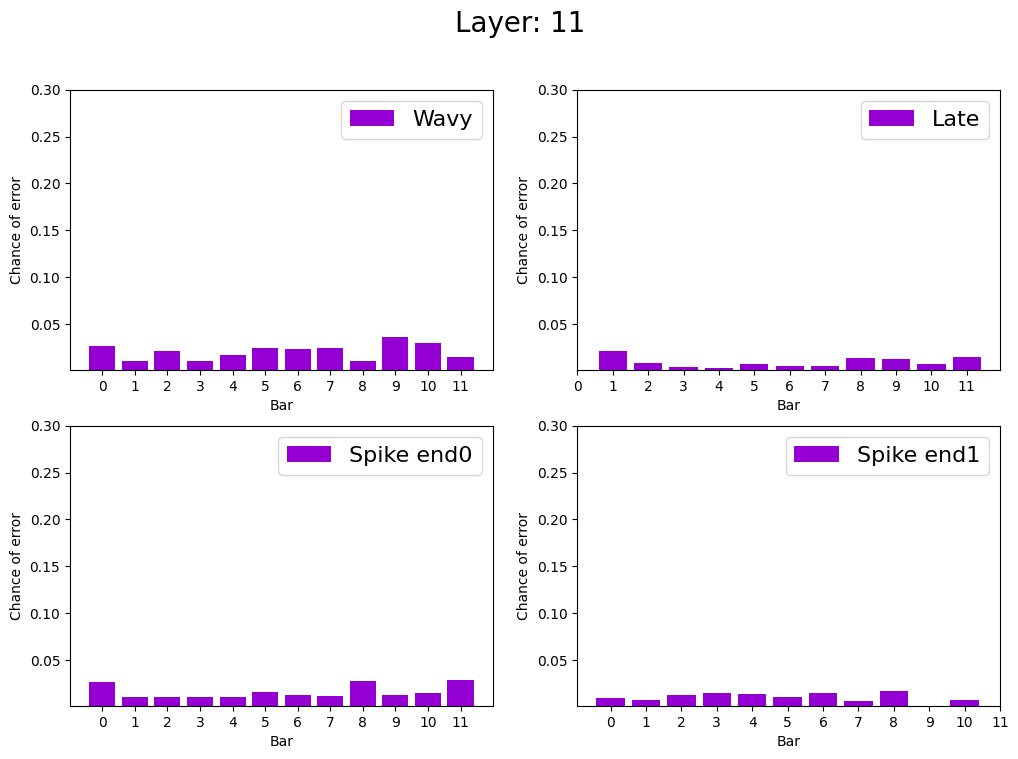

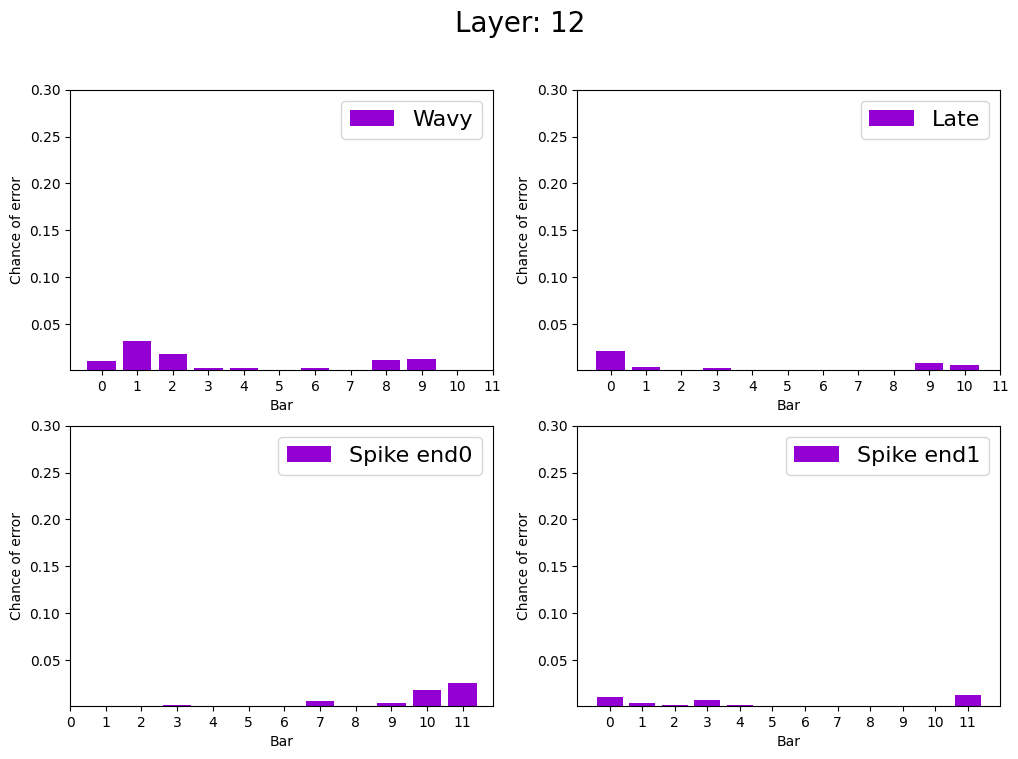

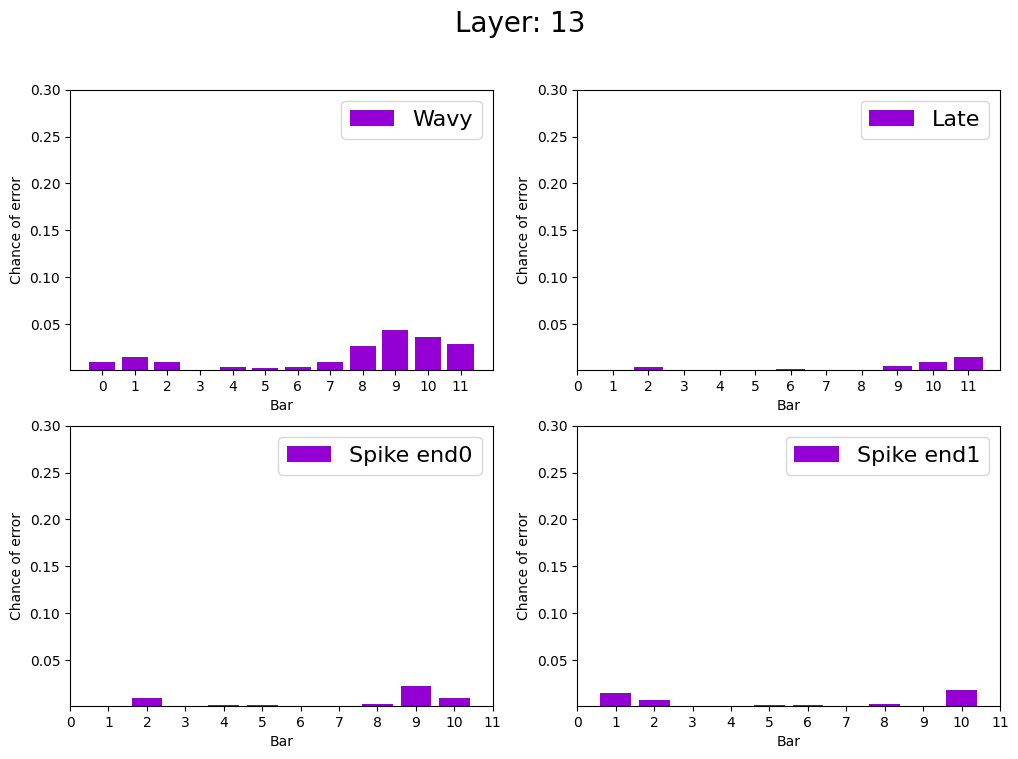

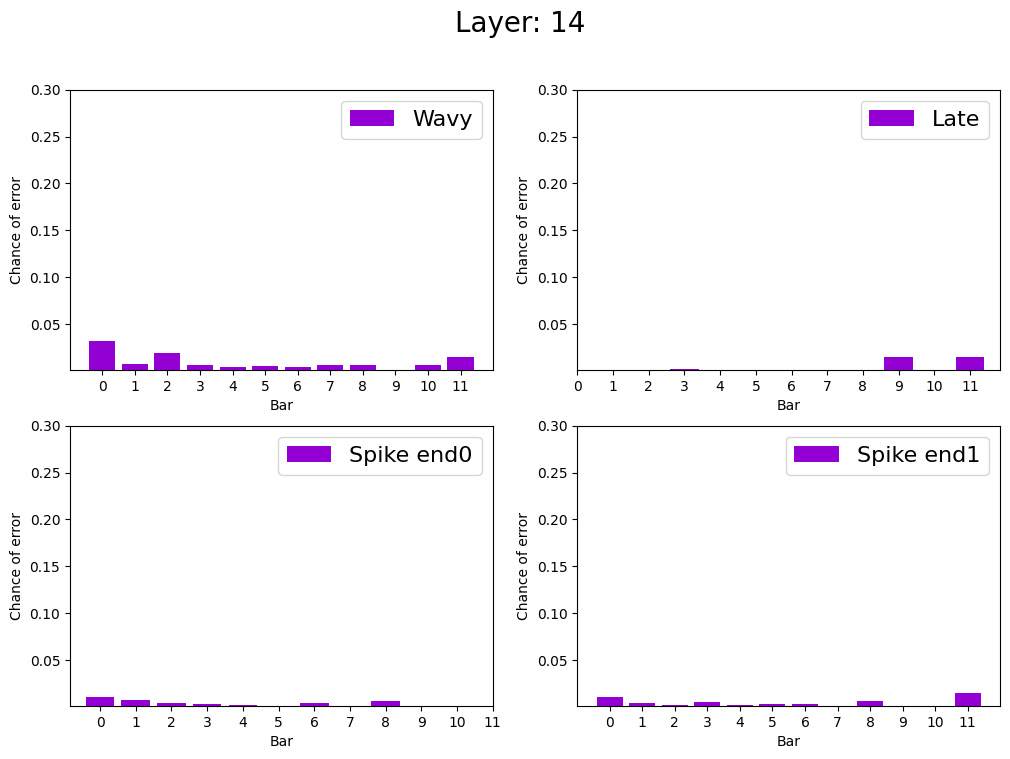

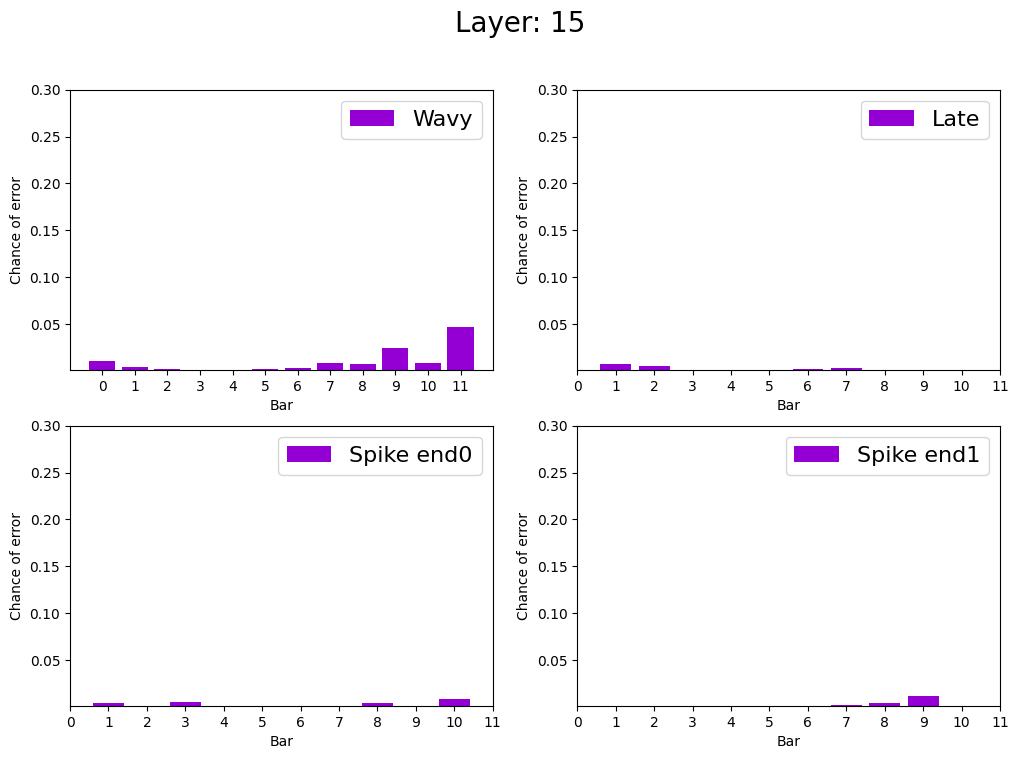

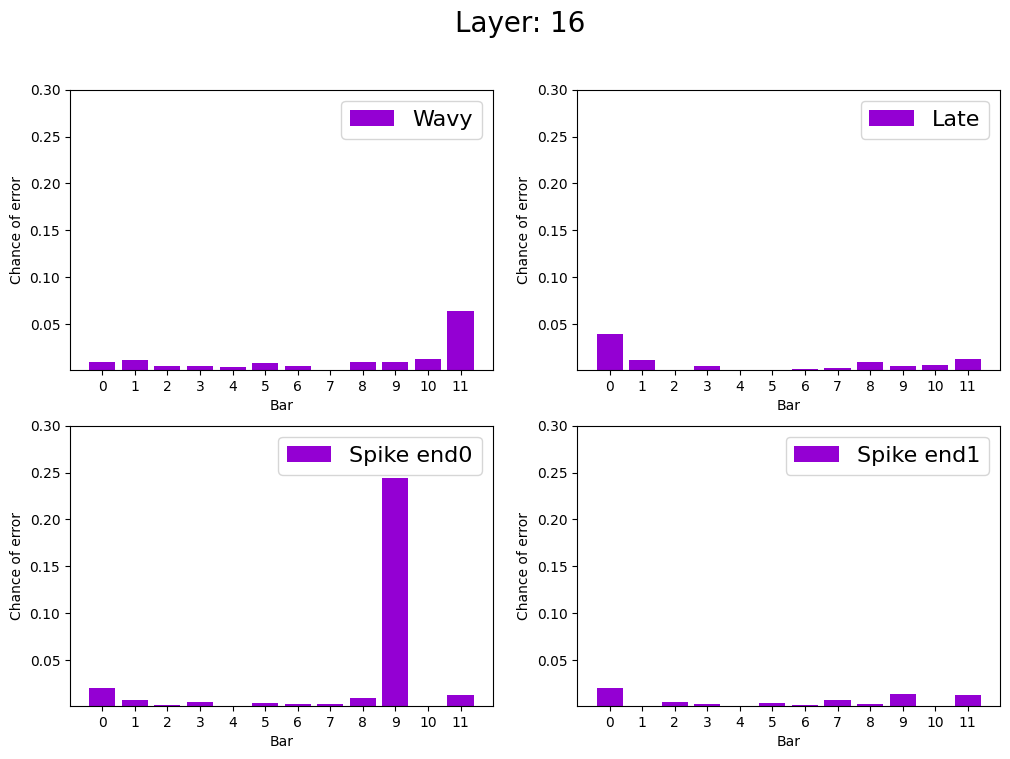

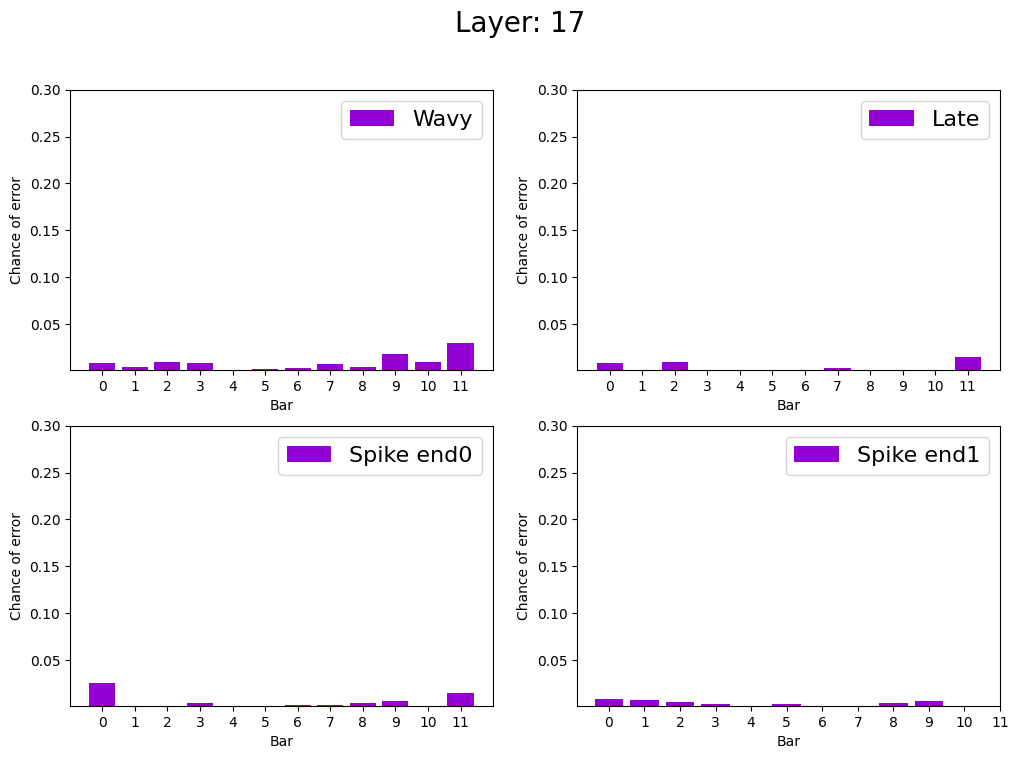

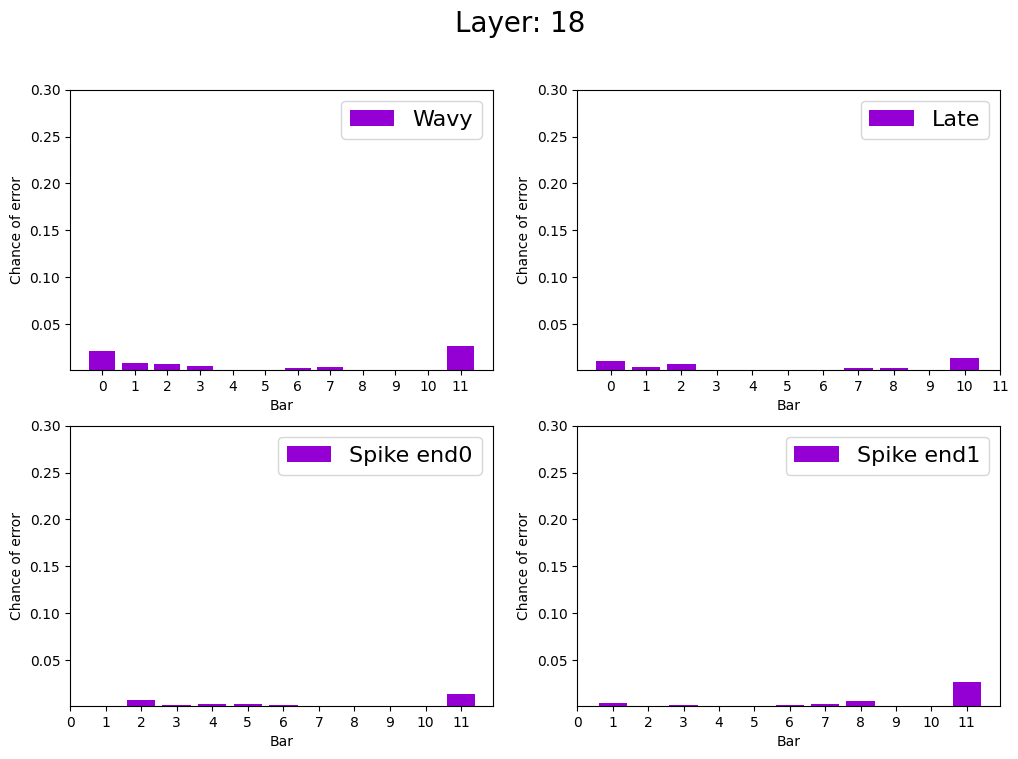

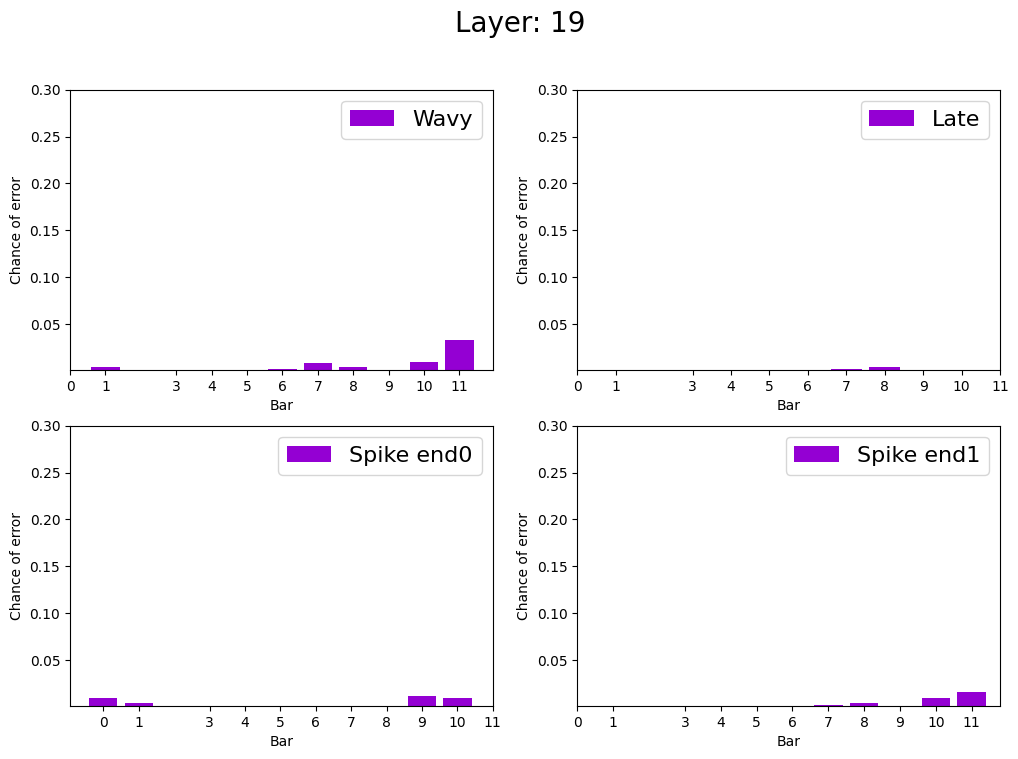

In [117]:
events_by_bar=big_df.groupby(["layer", "bar"]).count()[["event"]]

wave_chance=big_df[big_df["problem_type"]=="WAVE"].groupby(["layer","bar"]).count()[["event"]]/events_by_bar
late_chance=big_df[big_df["problem_type"]=="LATE"].groupby(["layer","bar"]).count()[["event"]]/events_by_bar
spike0_chance=big_df[big_df["problem_type"]=="SPIKE_0"].groupby(["layer","bar"]).count()[["event"]]/events_by_bar
spike1_chance=big_df[big_df["problem_type"]=="SPIKE_1"].groupby(["layer","bar"]).count()[["event"]]/events_by_bar
for l in range(1,20):
    plt.suptitle("Layer: "+str(l), fontsize=20)
    
    helper_df=wave_chance.query('layer == @l').droplevel(0)
    plt.subplot(2,2,1)
    plt.bar(helper_df.index,helper_df["event"],color="darkviolet", label="Wavy")
    plt.xticks(helper_df.index)
    plt.xlabel("Bar")
    plt.ylabel("Chance of error")
    plt.legend(loc="upper right", prop={'size': 16})
    plt.ylim(1e-3,0.3)
    #plt.yscale('log')

    
    helper_df=late_chance.query('layer == @l').droplevel(0)
    plt.subplot(2,2,2)
    plt.bar(helper_df.index,helper_df["event"],color="darkviolet", label="Late")
    plt.xticks(helper_df.index)
    plt.xlabel("Bar")
    plt.ylabel("Chance of error")
    plt.legend(loc="upper right", prop={'size': 16})
    plt.ylim(1e-3,0.3)
    #plt.yscale('log')

    helper_df=spike0_chance.query('layer == @l').droplevel(0)
    plt.subplot(2,2,3)
    plt.bar(helper_df.index,helper_df["event"],color="darkviolet", label="Spike end0")
    plt.xticks(helper_df.index)
    plt.xlabel("Bar")
    plt.ylabel("Chance of error")
    plt.legend(loc="upper right", prop={'size': 16})
    plt.ylim(1e-3,0.3)
    #plt.yscale('log')

    helper_df=spike1_chance.query('layer == @l').droplevel(0)
    plt.subplot(2,2,4)
    plt.bar(helper_df.index,helper_df["event"],color="darkviolet", label="Spike end1")
    plt.xticks(helper_df.index)
    plt.xlabel("Bar")
    plt.ylabel("Chance of error")
    plt.legend(loc="upper right", prop={'size': 16})
    plt.ylim(1e-3,0.3)
    #plt.yscale('log')

    
    plt.show()